In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

import seaborn as sns
color_pal = sns.color_palette()

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5 
plt.rcParams['lines.markersize'] = 4
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14

In [89]:
df = pd.read_csv(r"..\new_datasets\datos_gramineas.csv")
df['fecha'] = pd.to_datetime(df['fecha'])

### Prueba con 2024

In [90]:
FEATURES = [
    'NO2 (ug/m3)', 'O3 (ug/m3)', 'PM10 (ug/m3)', 'PM2.5 (ug/m3)', 'CO (mg/m3)', 'SO2 (ug/m3)',
    'Benceno (ug/m3)', 'Tolueno (ug/m3)', 'NO (ug/m3)', 'NOx (ug/m3)',
    
    'temperature_2m (°C)', 'wind_speed_10m (km/h)', 'wind_gusts_10m (km/h)',
    'relative_humidity_2m (%)', 'wind_direction_10m (°)', 'et0_fao_evapotranspiration (mm)',
    'dew_point_2m (°C)', 'rain (mm)', 'vapour_pressure_deficit (kPa)',
    'cloud_cover (%)', 'shortwave_radiation (W/m²)'
]

for col in FEATURES.copy():
    for i in range(1, 4):
        FEATURES.append(f'{col}_lag_{i}')

FEATURES += [
    'precip_autumn_last_year', 'precip_winter_last_year',
    'temp_mean_spring_summer_last', 'humidity_sum_spring_summer_last',
    'co2_mean_april_may_last', 'o3_mean_april_may_last', 
    'no2_mean_april_may_last', 'drought_days_summer_last', 
    'growing_degree_days_last'
]

FEATURES += ['polen_rolling_mean_3d', 'polen_rolling_mean_7d', 'polen_trend_3d', 'polen_accel']

for i in range(1, 8):
    FEATURES.append(f'polen_lag_{i}')

for i in range(1, 8):
    for col in ['polen_rolling_mean_3d', 'polen_rolling_mean_7d']:
         FEATURES.append(f'{col}_lag_{i}')

for h in [1, 2, 3]:
    FEATURES += [f'temperature_forecast_t+{h}', f'rain_forecast_t+{h}', f'humidity_forecast_t+{h}']

In [91]:
df['target_diff'] = df['granos_de_polen_x_metro_cubico'].diff()
TARGET = 'target_diff'

train_data = df[df['fecha'].dt.year < 2024].dropna(subset=[TARGET])
test_data = df[df['fecha'].dt.year == 2024].dropna(subset=[TARGET])

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]

In [92]:
# Añadir pesos
def calculate_weights(target_y, features_X):
    weights = np.ones(len(target_y))
    weights[target_y >= 50] = 100.0
    if 'polen_lag_1' in features_X.columns:
        jump = target_y - features_X['polen_lag_1']
        weights[jump >= 100] = 700.0
    return weights

pesos = calculate_weights(y_train, X_train)


In [93]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=741,
                        max_depth=5,
                        objective='reg:squarederror',
                        learning_rate=0.05016743214009948,
                        subsample=0.5778327912021376,
                        colsample_bytree=0.5242898344250857,
                        gamma=3.9902020819584716)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100, sample_weight=pesos)

preds = reg.predict(test_data[FEATURES])
test_data['prediccion'] = preds

[0]	validation_0-rmse:22.97150	validation_1-rmse:20.23241


[100]	validation_0-rmse:6.06544	validation_1-rmse:18.84185
[200]	validation_0-rmse:3.52528	validation_1-rmse:18.71429
[300]	validation_0-rmse:2.54376	validation_1-rmse:18.78910
[400]	validation_0-rmse:2.01520	validation_1-rmse:18.84510
[500]	validation_0-rmse:1.65585	validation_1-rmse:18.87062
[600]	validation_0-rmse:1.33631	validation_1-rmse:18.84505
[700]	validation_0-rmse:1.10244	validation_1-rmse:18.82471
[740]	validation_0-rmse:1.01812	validation_1-rmse:18.82038


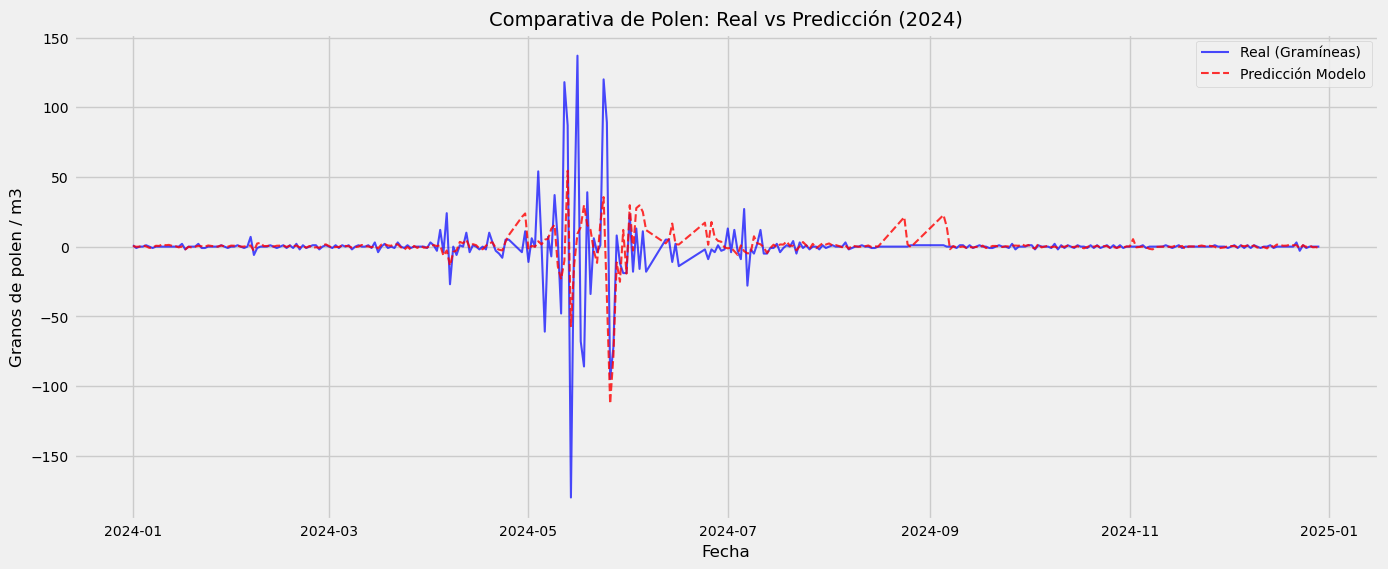

--- Métricas para el año 2024 ---
Error Medio Absoluto (MAE): 6.20 granos
Coeficiente de determinación (R2): 0.17


In [94]:
# Visualizar todo el año

plt.figure(figsize=(15, 6))

plt.plot(test_data['fecha'], test_data[TARGET], label='Real (Gramíneas)', color='blue', alpha=0.7)
plt.plot(test_data['fecha'], test_data['prediccion'], label='Predicción Modelo', color='red', linestyle='--', alpha=0.8)

plt.title(f'Comparativa de Polen: Real vs Predicción (2024)')
plt.xlabel('Fecha')
plt.ylabel('Granos de polen / m3')
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(test_data[TARGET], test_data['prediccion'])
r2 = r2_score(test_data[TARGET], test_data['prediccion'])

print(f"--- Métricas para el año 2024 ---")
print(f"Error Medio Absoluto (MAE): {mae:.2f} granos")
print(f"Coeficiente de determinación (R2): {r2:.2f}")

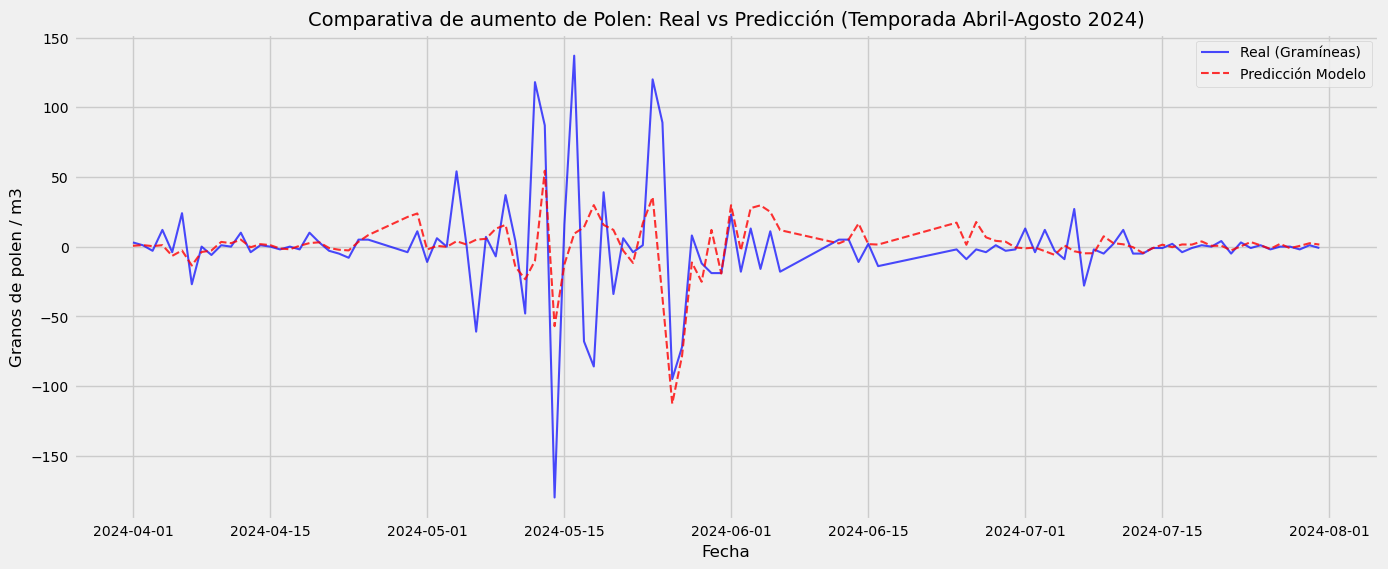

--- Métricas para el periodo Abril-Agosto 2024 ---
Error Medio Absoluto (MAE): 16.95 granos
Coeficiente de determinación (R2): 0.18


In [95]:
# Solo meses importantes

test_data_temporada = test_data[test_data['fecha'].dt.month.between(4, 7)].copy()

plt.figure(figsize=(15, 6))

plt.plot(test_data_temporada['fecha'], test_data_temporada[TARGET], 
         label='Real (Gramíneas)', color='blue', alpha=0.7)
plt.plot(test_data_temporada['fecha'], test_data_temporada['prediccion'], 
         label='Predicción Modelo', color='red', linestyle='--', alpha=0.8)

plt.title(f'Comparativa de aumento de Polen: Real vs Predicción (Temporada Abril-Agosto 2024)')
plt.xlabel('Fecha')
plt.ylabel('Granos de polen / m3')
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(test_data_temporada[TARGET], test_data_temporada['prediccion'])
r2 = r2_score(test_data_temporada[TARGET], test_data_temporada['prediccion'])

print(f"--- Métricas para el periodo Abril-Agosto 2024 ---")
print(f"Error Medio Absoluto (MAE): {mae:.2f} granos")
print(f"Coeficiente de determinación (R2): {r2:.2f}")

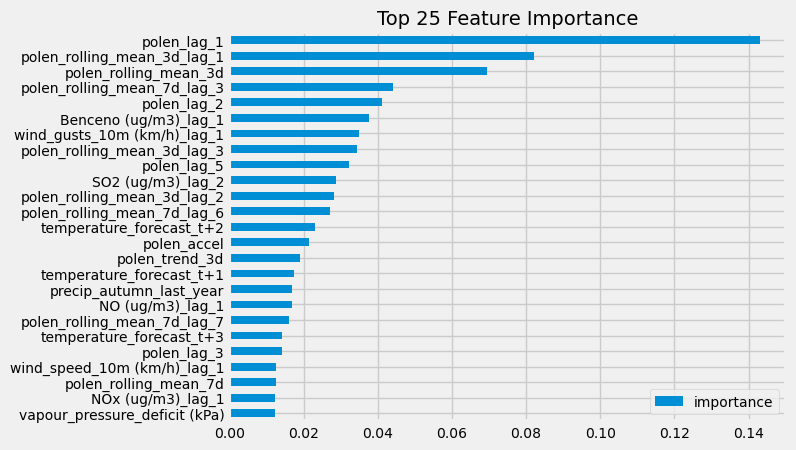

In [96]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance', ascending=False).head(25).sort_values('importance').plot(kind='barh', title='Top 25 Feature Importance')
plt.show()

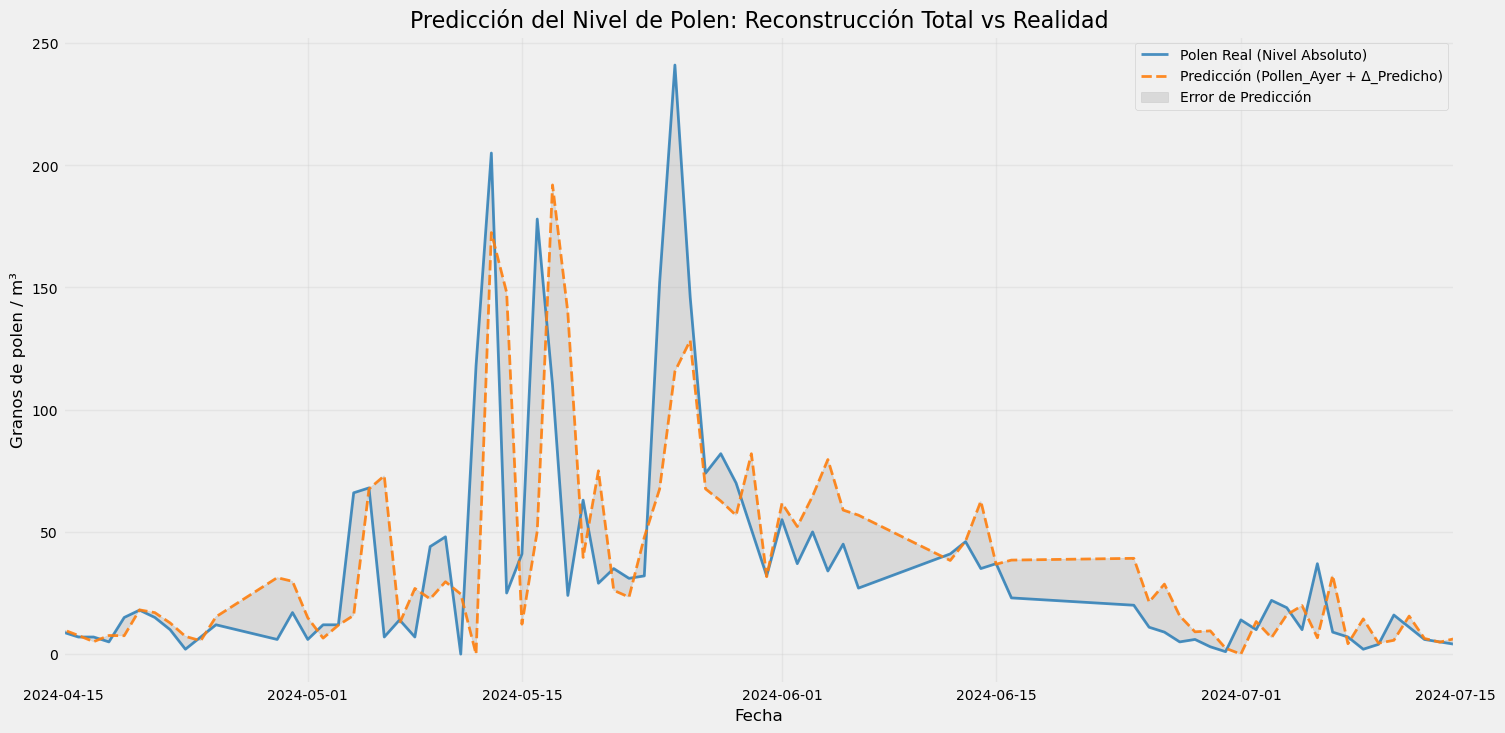

Análisis de Picos (>100 granos):
Error Medio en días de picos: 83.96 granos


In [97]:
# --- Celda: Reconstrucción de Valores Absolutos y Comparativa de Picos ---

# 1. Reconstruimos el valor absoluto: Ayer + Variación Predicha
test_data['prediccion_absoluta'] = test_data['polen_lag_1'] + test_data['prediccion']

# 2. Forzamos a que no haya valores negativos (el polen no puede ser < 0)
test_data['prediccion_absoluta'] = test_data['prediccion_absoluta'].clip(lower=0)

# 3. Visualización
plt.figure(figsize=(16, 8))

# Línea del valor real
plt.plot(test_data['fecha'], test_data['granos_de_polen_x_metro_cubico'], 
         label='Polen Real (Nivel Absoluto)', color='#1f77b4', linewidth=2, alpha=0.8)

# Línea de tu predicción (Ayer + Delta)
plt.plot(test_data['fecha'], test_data['prediccion_absoluta'], 
         label='Predicción (Pollen_Ayer + Δ_Predicho)', color='#ff7f0e', 
         linestyle='--', linewidth=2, alpha=0.9)

# Sombreado para resaltar la diferencia (opcional, ayuda a ver el error)
plt.fill_between(test_data['fecha'], 
                 test_data['granos_de_polen_x_metro_cubico'], 
                 test_data['prediccion_absoluta'], 
                 color='gray', alpha=0.2, label='Error de Predicción')

plt.title('Predicción del Nivel de Polen: Reconstrucción Total vs Realidad', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Granos de polen / m³', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom automático a la temporada de picos (por ejemplo, Mayo y Junio)
# Esto te permite ver si la línea naranja "salta" junto a la azul
plt.xlim(pd.Timestamp('2024-04-15'), pd.Timestamp('2024-07-15')) 

plt.show()

# --- Métricas de Calidad en Picos ---
picos_reales = test_data[test_data['granos_de_polen_x_metro_cubico'] > 100]
mae_picos = mean_absolute_error(picos_reales['granos_de_polen_x_metro_cubico'], picos_reales['prediccion_absoluta'])

print(f"Análisis de Picos (>100 granos):")
print(f"Error Medio en días de picos: {mae_picos:.2f} granos")

### Predecir el próximo día

In [98]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [99]:
df = pd.read_csv(r"..\new_datasets\datos_gramineas.csv")
df = df.set_index("fecha")
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending=True)

In [100]:
model = xgb.Booster()
model.load_model('modelo_t+1.json')

features_que_pide_el_modelo = model.feature_names

In [101]:
ultima_fila = df.tail(6)

input_data = ultima_fila[features_que_pide_el_modelo]

In [102]:
dmatrix_input = xgb.DMatrix(input_data)

prediccion_raw = model.predict(dmatrix_input)[0]

print(f"La predicción de polen para el próximo día es: {prediccion_raw:.2f}")

La predicción de polen para el próximo día es: 0.62
